# Ручное тестирование библиотеки 

Импортируем нужные модули

In [1]:
# входная точка фреймворка
from fedcore.api.main import FedCore 
# использование встроенных подгрузчиков данных
from fedcore.data.dataloader import load_data
# подгрузка модели для сжатия
from torchvision.models import resnet18, ResNet18_Weights 

# объекты для настройки FedCore 
from fedcore.api.config_factory import ConfigFactory 
from fedcore.api.api_configs import *

/home/leostre/.local/share/virtualenvs/FedCore-wPuHcacz/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/leostre/.local/share/virtualenvs/FedCore-wPuHcacz/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


2025-11-24 17:12:24,301 - Device <cuda:0> is selected
2025-11-24 17:12:24,301 - Device <cuda:0> is selected
2025-11-24 17:12:24,301 - Device <cuda:0> is selected


In [18]:
initial_assumption = resnet18(ResNet18_Weights)

DATASET = 'mnist'
DATASET_PARAMS = {'train_bs': 64,
                  'val_bs': 100,
                  'train_shuffle': True,
                  'val_shuffle': False}

METRIC_TO_OPTIMISE = ['accuracy', 'latency', 'throughput']


APIConfig = ConfigFactory.from_template(
    APIConfigTemplate(
        None,
        AutoMLConfigTemplate(
            FedotConfigTemplate(
            problem='classification',
            pop_size=1,
            timeout=1,
            initial_assumption=initial_assumption
            )
        ),
        LearningConfigTemplate(
            criterion='cross_entropy',
            learning_strategy='from_scratch',
            peft_strategy_params=[LowRankTemplate(
                epochs=1,
                non_adaptive_threshold=0.1
            )],
        )
    )
)

api_config = APIConfig() # Here we can update with kwargs

@@@ LearningConfig peft_strategy_params [(<class 'fedcore.api.api_configs.LowRankTemplate'>, OrderedDict([('log_each', LookUp(value=None)), ('eval_each', LookUp(value=None)), ('save_each', LookUp(value=None)), ('epochs', 1), ('optimizer', 'adam'), ('scheduler', None), ('criterion', LookUp(value=None)), ('custom_learning_params', None), ('custom_criterions', None), ('model_architecture', None), ('strategy', 'quantile'), ('rank_prune_each', -1), ('compose_mode', None), ('non_adaptive_threshold', 0.1), ('finetune_params', None)]))]
@@@ LowRank(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.1, finetune_params=Training(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', schedu

Для каждого поля в конфиге высвечивается подсказка типизации 
<br>
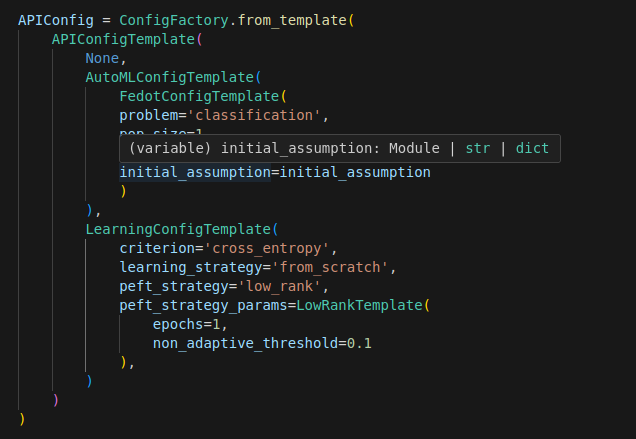

Некоторые поля проверяются на основании перечислений и классов из fedcore/repository/constants_repository.py 
<br>

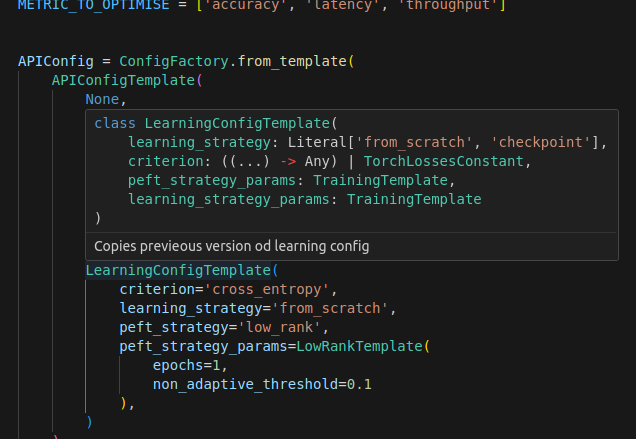

In [3]:
from fedcore.repository.constanst_repository import TorchLossesConstant 

TorchLossesConstant._member_names_

['cross_entropy',
 'binary_cross_entropy',
 'mse',
 'kl',
 'rmse',
 'smape',
 'tweedy',
 'focal',
 'center_plus',
 'center',
 'masked',
 'log_cosh',
 'huber',
 'exp_weighted']

После создания объекта конфигурации можно обновить отдельные поля с помощью метода update. Для обновления вложенных конфигураций можно использовать названия их полей, написанные через `.` 

In [4]:
api_config.update({'learning_config.criterion': 'binary_cross_entropy'})

Обращение к полям возможно как через `.`, так и через `[]`

In [5]:
api_config.learning_config

LearningConfig(learning_strategy='from_scratch', criterion='binary_cross_entropy', peft_strategy_params=[(<class 'fedcore.api.api_configs.TrainingTemplate'>, OrderedDict([('log_each', LookUp(value=None)), ('eval_each', LookUp(value=None)), ('save_each', LookUp(value=None)), ('epochs', 1), ('optimizer', 'adam'), ('scheduler', None), ('criterion', LookUp(value=None)), ('custom_learning_params', None), ('custom_criterions', None), ('model_architecture', None)])), (<class 'fedcore.api.api_configs.TrainingTemplate'>, OrderedDict([('log_each', LookUp(value=None)), ('eval_each', LookUp(value=None)), ('save_each', LookUp(value=None)), ('epochs', 1), ('optimizer', 'adam'), ('scheduler', None), ('criterion', LookUp(value=None)), ('custom_learning_params', None), ('custom_criterions', None), ('model_architecture', None)]))], learning_strategy_params=Training(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, cust

In [6]:
api_config['learning_config']['criterion']

'binary_cross_entropy'

## Cоздание предопределённых конфигураций

In [7]:
CVClassificationConfig = ConfigFactory.from_template(
    APIConfigTemplate(
        automl_config=AutoMLConfigTemplate(
            FedotConfigTemplate(
            problem='classification',
            initial_assumption='Resnet18'
            )
        ),
        learning_config=LearningConfigTemplate(
            criterion='cross_entropy',
            peft_strategy_params=[LowRankTemplate(
                epochs=1,
                non_adaptive_threshold=0.1
            )],
        )
    )
)

Разработанный фабричный метод позволяет производить новые классы с предопределёнными параметрами по умолчанию. В результате создаётся новый класс

In [8]:
type(CVClassificationConfig)

type

Наследующий всю логику изначального APIConfig

In [9]:
CVClassificationConfig.__mro__

(fedcore.api.config_factory.APIConfig,
 fedcore.api.api_configs.APIConfigTemplate,
 fedcore.api.api_configs.ExtendableConfigTemplate,
 fedcore.api.api_configs.ConfigTemplate,
 object)

In [10]:
cv_clf_conf = CVClassificationConfig()
cv_clf_conf

@@@ LearningConfig peft_strategy_params [(<class 'fedcore.api.api_configs.LowRankTemplate'>, OrderedDict([('log_each', LookUp(value=None)), ('eval_each', LookUp(value=None)), ('save_each', LookUp(value=None)), ('epochs', 1), ('optimizer', 'adam'), ('scheduler', None), ('criterion', LookUp(value=None)), ('custom_learning_params', None), ('custom_criterions', None), ('model_architecture', None), ('strategy', 'quantile'), ('rank_prune_each', -1), ('compose_mode', None), ('non_adaptive_threshold', 0.1), ('finetune_params', None)]))]
@@@ LowRank(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.1, finetune_params=Training(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', schedu

APIConfig(device_config=DeviceConfig(device='cuda', inference='onnx'), automl_config=AutoMLConfig(fedot_config=FedotConfig(timeout=10.0, pop_size=5, early_stopping_iterations=10, early_stopping_timeout=10, with_tuning=False, problem='classification', task_params=None, metric='', n_jobs=-1, initial_assumption='Resnet18', available_operations='', optimizer=None), mutation_agent='random', mutation_strategy='params_mutation_strategy', optimizer=None), learning_config=LearningConfig(learning_strategy='from_scratch', criterion='cross_entropy', peft_strategy_params=[LowRank(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.1, finetune_params=Training(log_each=0, eval_each=0, save_each=0, epochs=

Полученный конфиг соответствует всей функциональности конфига и может быть дополнительно модифицирован на усмотрение пользователя.

## Встроенная валидация значений

В качестве начального приближения используется

In [13]:
type(api_config.automl_config.fedot_config.initial_assumption)

torchvision.models.resnet.ResNet

Попытка назначить атрибут класса, не соответствующий аннотации шаблона конфигурации спроектировано так, что приводит к выбрасыванию ошибки MisconfigurationError. В сообщении этой ошибки перечисляются все обнаруженные неточности при создании конфигурации. Например, в примере ниже указывается, что значение `0.0` не может быть передано в качестве `initial_assumption`, т.к. ожидается либо наследник torch.nn.modules.module.Module, либо строка название модели, либо словарь {путь к чекпоинту, архитектура модели}

In [19]:
api_config.automl_config.fedot_config.initial_assumption = 0.

MisconfigurationError: 	`Passed `0.0` at config: FedotConfig, field: initial_assumption. Expected: <class 'torch.nn.modules.module.Module'>
	`Passed `0.0` at config: FedotConfig, field: initial_assumption. Expected: <class 'str'>
	`Passed `0.0` at config: FedotConfig, field: initial_assumption. Expected: <class 'dict'>

Это помогает избегать опечаток при конфигурации

In [20]:
api_config.learning_config

LearningConfig(learning_strategy='from_scratch', criterion='cross_entropy', peft_strategy_params=[LowRank(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.1, finetune_params=Training(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={})))], learning_strategy_params=Training(log_each=0, eval_each=0, save_each=0, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_d

In [24]:
api_config.learning_config.peft_strategy_params[0].optimizer = 'adm'

MisconfigurationError: 	`adm` not supported as optimizer at config LowRank. Options: ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta']

На основании сообщений можно скорректировать конфигурацию до рабочей версии:

In [23]:
api_config.learning_config.peft_strategy_params[0].optimizer = 'adamw'

### Автоматическое заполнение полей 

При сборке конфигурации из шаблона существует система подхватывания полей из вышестоящих конфигураций 

Например:

<br>

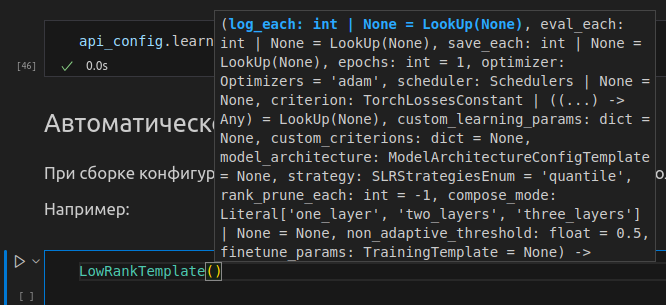

<br>

Обратим внимание на поля со значением LookUp

In [ ]:
LookUpConfig = ConfigFactory.from_template(
    APIConfigTemplate(
        None,
        AutoMLConfigTemplate(
            FedotConfigTemplate(
            problem='classification',
            pop_size=1,
            timeout=1,
            initial_assumption=initial_assumption
            )
        ),
        LearningConfigTemplate(
            criterion='mse',
            learning_strategy='from_scratch',
            peft_strategy_params=LowRankTemplate(
                epochs=1,
                non_adaptive_threshold=0.1
            ),
        )
))

look_up = LookUpConfig() 

Заметим, что мы указали `criterion='mse'` только cлоя верхнеуровневой конфигурации `LearningConfigTemplate`, проверим функцию потерь внутри `peft_strategy_params`

In [ ]:
look_up.learning_config.peft_strategy_params.criterion

AttributeError: 'list' object has no attribute 'criterion'

Как можно видеть, существующее API позволяет пользователю указывать верхнеуровневые настройки единожды, чтобы распространить их значение на все вложенные конфигурации